In [36]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
import cv2
import pandas as pd
import ntpath
import random

In [37]:
#display first 5 rows of data from csv

columns= ('center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed')
data = pd.read_csv(('driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', None)

In [38]:
#clear path from jpg files

def path_leaf(path):
    head, tail=ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2022_10_12_13_21_10_965.jpg,left_2022_10_12_13_21_10_965.jpg,right_2022_10_12_13_21_10_965.jpg,0.0,0.0,0.0,0.000078
1,center_2022_10_12_13_21_11_066.jpg,left_2022_10_12_13_21_11_066.jpg,right_2022_10_12_13_21_11_066.jpg,0.0,0.0,0.0,0.000078
2,center_2022_10_12_13_21_11_167.jpg,left_2022_10_12_13_21_11_167.jpg,right_2022_10_12_13_21_11_167.jpg,0.0,0.0,0.0,0.000078
3,center_2022_10_12_13_21_11_270.jpg,left_2022_10_12_13_21_11_270.jpg,right_2022_10_12_13_21_11_270.jpg,0.0,0.0,0.0,0.000079
4,center_2022_10_12_13_21_11_371.jpg,left_2022_10_12_13_21_11_371.jpg,right_2022_10_12_13_21_11_371.jpg,0.0,0.0,0.0,0.000079


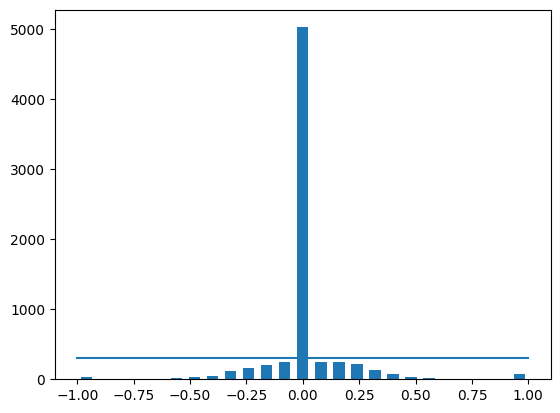

In [39]:
#draw histogram to show distribution of steering angles and select sample size per bin

num_bins = 25
samples_per_bin = 300
hist, bins =np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 6945
removed: 4729
remaining 2216


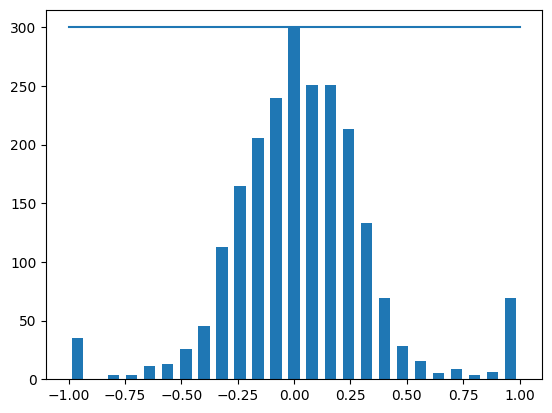

In [40]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)

    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
def load_img_steering(, )